# Import the data

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn import preprocessing
%matplotlib inline
pd.set_option('display.max_columns', None)

In [37]:
wine = pd.read_csv("../data/wine.csv")
wine

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [38]:
wine = wine.drop("index", axis=1)

# Visualising data

In [39]:
wine["quality"].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

There is a huge difference between the different occurences of quality. I may need to do something about it.

In [40]:
"""
g = sns.PairGrid(wine, hue="quality")
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()
"""

'\ng = sns.PairGrid(wine, hue="quality")\ng.map_diag(sns.histplot)\ng.map_lower(sns.scatterplot)\ng.add_legend()\n'

# Data preprocessing

In [41]:
X = wine.drop("quality", axis=1)
columns_names = X.columns
X = X.values
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns_names)

In [42]:
train_test_split_fraction = 0.80
split_index = int(X_scaled.shape[0] * train_test_split_fraction)
wine_train = X_scaled[:split_index]
wine_test = X_scaled[split_index:]

target = pd.DataFrame(wine["quality"])

In [43]:
target = pd.get_dummies(target["quality"])
#target["0"] = 0
#target["1"] = 0
#target["2"] = 0
#target["10"] = 0
target = target.values

In [44]:
X_train = wine_train.values
X_test = wine_test.values

y_train = target[:split_index]
y_test = target[split_index:]

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5197, 11)
(1300, 11)
(5197, 7)
(1300, 7)


# First NN

In [46]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [47]:
class First_Network(nn.Module):

    def __init__(self, nb_features):
        """Here we define the layers
        """

        super().__init__()
        
        self.layer_1 =  nn.Linear(nb_features, 10)
        self.layer_2 =  nn.Linear(10, 10)
        self.layer_3 =  nn.Linear(10, 7)
        
        

    def forward(self,x):
        """Here we combine the layers
        """
        
        #activation_function = nn.functional.relu()
        last_layer_activation = nn.Softmax(dim=1)
        
        output_first_layer = nn.functional.relu(self.layer_1(x))
        output_second_layer = nn.functional.relu(self.layer_2(output_first_layer))
        prediction = last_layer_activation(self.layer_3(output_second_layer))
        return prediction

In [48]:
first_nn = First_Network(nb_features=X_train.shape[1])
first_nn

First_Network(
  (layer_1): Linear(in_features=11, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=7, bias=True)
)

In [49]:
criterion = torch.nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(first_nn.parameters(), lr=learning_rate)

In [50]:
def training(batch_size : int, nb_steps_loss_sum : int):
    """ Train the neural network, feeding it `batch_size` at a time
    and saving statistics every `nb_steps_loss_sum` steps.
    
    Arguments:
    
    - batch_size [int] : the number of input samples at each training step (called a batch)
    - nb_steps_loss_sum [int] : the number of batches before saving the loss for plotting
    
    Returns:
    - loss_list : [List[double]] : value of the loss every `nb_steps_loss_sum` steps
    """

    loss_list = []
    running_loss = 0
    batch_nb = 0

    for epoch in range(0,10): # Number of times to iterate through the complete dataset
        for idx in range(0, X_train.shape[0], batch_size):
            
            # Get input and output
            input_batch = X_train[idx:idx + batch_size]
            target = y_train[idx:idx + batch_size]
            
            # TO COMPLETE:
            # - zero gradient buffers
            first_nn.zero_grad()
            # - compute the forward pass
            output = first_nn(input_batch)
            # - compute the loss
            loss = criterion(output, target)
            # - backpropagate
            loss.backward()
            # - do a step
            optimizer.step()
          
            # Save the loss every `running_loss_steps` batches
            running_loss += loss.item()
            save_loss_condition = batch_nb % nb_steps_loss_sum == (nb_steps_loss_sum - 1)
            if save_loss_condition:    
                loss_list.append(running_loss)
                running_loss = 0.0


            batch_nb+= 1
        
    return loss_list

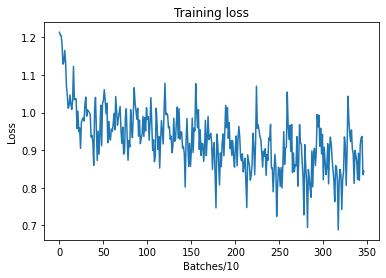

In [51]:
nb_steps_loss_sum = 10
loss = training(batch_size=15, nb_steps_loss_sum=nb_steps_loss_sum)

# Plotting the loss over training
plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlabel(f"Batches/{nb_steps_loss_sum}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [52]:
def computeScore(X, y):
    correct = 0
    total = 0
    batch_size = 1
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            # TO COMPLETE:
            # - get the `batch_size` number of input samples
            input_batch = X[idx:idx + batch_size]
            target = y[idx:idx + batch_size]
            # - compute the prediction of the neural network
            predictions = first_nn(input_batch)
            # - get the max of the prediction (e.g. get the most likely class)
            # This can be done using `torch.max`.
            max_predictions = torch.argmax(predictions)
            # - get the max of the target (e.g. correct class)
            max_target = torch.argmax(target)
            # - check if the prediction is correct and count it
            if max_predictions == max_target:
                correct += 1
            # - count every sample
            total += 1
            
    accuracy = correct/total * 100
    print(f"Accuracy of the network on the {total} samples: {accuracy:.2f}%")

In [53]:
computeScore(X_train, y_train)
computeScore(X_test, y_test)

Accuracy of the network on the 5197 samples: 52.40%
Accuracy of the network on the 1300 samples: 54.15%


# hyperparameter tuning